<a href="https://colab.research.google.com/github/aolieman/semantic-corpus-exploration/blob/master/notebooks/semantic_corpus_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part III: Semantic Corpus Exploration

## Initialization

In [0]:
!pip install internetarchive pyspotlight SPARQLWrapper

In [0]:
import glob
import itertools
import json
import os
from collections import defaultdict
from urllib.request import urlretrieve

import pandas as pd
import spotlight
import IPython.display as display
from google.colab import files
from internetarchive import download
from ipywidgets import interact, interactive, IntSlider
from tqdm import tqdm, tqdm_notebook
from SPARQLWrapper import SPARQLWrapper, JSON

# Pandas configuration
pd.options.display.max_colwidth=75

## Loading documents

Download a collection or item from the Internet Archive.

The provided example was found in [The Magazine Rack](https://archive.org/details/magazine_rack).

In [0]:
archive_name = "TheStrandMagazineAnIllustratedMonthly"
download(archive_name, verbose=True, formats='DjVuTXT')

Read the downloaded files into a Pandas DataFrame

In [4]:
file_paths, file_contents = [], []
for file_path in glob.iglob(f'{archive_name}/*.txt'):
    file_paths.append(file_path)
    with open(file_path, 'r', encoding='utf8') as f:
        text_content = f.read()
        file_contents.append(text_content)
    
document_df = pd.DataFrame(data={
    'file_path': file_paths,
    'text_content': file_contents
})

document_df.head(5)

,file_path,text_content
0,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,"! v'C \n\n;:s#r r \n, : .* • \n\n\n. &*., \n\n\n\n\ngpr. \n\n\nkm \n\n\..."
1,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1912aVol.XliiiJa...,Digiiiz&tf by Google \n\n\nOriginal from \nUNIVERSITY OF MICHIGAN \n\n\...
2,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1911aVol.XliJan-...,by Google \n\n\nOriginal from \nUNIVERSITY OF MICHIGAN \n\n\n\n\n\n\n\n...
3,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1906bVol.XxxiiJu...,\nThe strand magazine \n\nOriginal from \n\nDigitized by VjOOgie UNIVER...
4,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1901bVol.XxiiJul...,\nThe strand magazine \n\n\nDigitized by GoOgk \n\n\nOriginal from \nUN...


## Entity Linking with Spotlight

In [0]:
def annotate_files(input_texts):
    annotations = []
    spotlight_endpoint = 'https://cleverdon.hum.uva.nl/spotlight/en/rest/annotate'
    for file_text in tqdm_notebook(input_texts, desc='Spotlight EL'):
        try:
            file_annotations = spotlight.annotate(
                spotlight_endpoint, 
                file_text,
                confidence=0.5
            )
        except Exception as e:
            tqdm.write(str(e))
            file_annotations = []

        annotations.append(file_annotations)
  
    return annotations

# uncomment the next line to annotate the downloaded documents
# annotations = annotate_files(file_contents)

It is advisable to dump these annotations to json files, compress them into an archive, and to download the resulting file to your laptop.

In [0]:
def dump_annotations(dump_name, input_file_paths, annotations):
    for fp, ann in zip(input_file_paths, annotations):
        out_path = os.path.join(dump_name, f'{os.path.basename(fp)}.json')
        os.makedirs(dump_name, exist_ok=True)
        with open(out_path, 'w') as f:
            json.dump(ann, f)
            print(f'{fp} annotations saved to {out_path}')

In [0]:
# uncomment this line to dump the annotations
# dump_annotations('my-annotations', file_paths, annotations)

In [0]:
# uncomment this line to compress the annotations
# after running this cell, make a local copy via the Colab file browser
# !tar -czvf my-annotations.tar.gz my-annotations

To load previously dumped annotations, upload your local dump, or fetch a dump from a url.

Extract the compressed archive before loading the annotations into memory.

In [9]:
dump_url = 'https://cleverdon.hum.uva.nl/sce-tutorial/tmr-annotations.tar.gz'
urlretrieve(dump_url, dump_url.split('/')[-1])

('tmr-annotations.tar.gz', <http.client.HTTPMessage at 0x7fdfbff58860>)

In [0]:
!tar -xzvf tmr-annotations.tar.gz

In [11]:
def load_annotations(dump_name, file_paths):
    annotations = []
    for fp in tqdm_notebook(file_paths, desc='Loading annotations'):
        json_path = os.path.join(dump_name, f'{os.path.basename(fp)}.json')
        with open(json_path) as f:
            file_annotations = json.load(f)
      
        annotations.append(file_annotations)
    
    return annotations

annotations = load_annotations('tmr-annotations', file_paths)
len(annotations)

64

Once annotations have been loaded into memory, we can put them in a DataFrame which will allow "joining" them with the input documents in a later step.

In [12]:
def make_annotation_df(input_file_paths, annotations):
    for fp, file_annotations in tqdm_notebook(
        zip(input_file_paths, annotations),
        total=len(input_file_paths),
        desc='Files'
    ):
        for ann in file_annotations:
            ann['source_file'] = fp
            if hasattr(ann['types'], 'split'):
                ann['types'] = set(ann['types'].split(','))
            
    print('Loading annotations into a DataFrame...')
            
    return pd.DataFrame.from_records(
        itertools.chain.from_iterable(annotations)
    )

annotation_df = make_annotation_df(file_paths, annotations)
annotation_df.head(10)


Loading annotations into a DataFrame...


,URI,offset,percentageOfSecondRank,similarityScore,source_file,support,surfaceForm,types
0,http://dbpedia.org/resource/V.,111,0.000000e+00,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,42,V.,"{DBpedia:Work, Schema:CreativeWork, Schema:Book, Http://purl.org/ontolo..."
1,http://dbpedia.org/resource/The_Strand_Magazine,255,0.000000e+00,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,306,The strand magazine,"{DBpedia:Work, DBpedia:Magazine, DBpedia:PeriodicalLiterature, Schema:C..."
2,http://dbpedia.org/resource/Michigan,337,1.568031e-01,0.828446,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,37120,MICHIGAN,"{Schema:Place, DBpedia:Region, Schema:AdministrativeArea, DBpedia:Place..."
3,http://dbpedia.org/resource/Michigan,442,1.568031e-01,0.828446,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,37120,MICHIGAN,"{Schema:Place, DBpedia:Region, Schema:AdministrativeArea, DBpedia:Place..."
4,http://dbpedia.org/resource/University_of_Michigan,502,9.199007e-04,0.998721,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,12941,UNIVERSITY OF MICHIGAN,"{DBpedia:EducationalInstitution, DBpedia:Agent, Schema:Organization, DB..."
5,http://dbpedia.org/resource/University_of_Michigan,569,9.199007e-04,0.998721,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,12941,UNIVERSITY OF MICHIGAN,"{DBpedia:EducationalInstitution, DBpedia:Agent, Schema:Organization, DB..."
6,http://dbpedia.org/resource/University_of_Michigan,693,9.199007e-04,0.998721,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,12941,UNIVERSITY OF MICHIGAN,"{DBpedia:EducationalInstitution, DBpedia:Agent, Schema:Organization, DB..."
7,http://dbpedia.org/resource/University_of_Michigan,735,9.199007e-04,0.998721,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,12941,UNIVERSITY OF MICHIGAN,"{DBpedia:EducationalInstitution, DBpedia:Agent, Schema:Organization, DB..."
8,http://dbpedia.org/resource/GEO_(magazine),824,2.807921e-02,0.967111,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,74,GEO,"{DBpedia:Work, DBpedia:Magazine, DBpedia:PeriodicalLiterature, Schema:C..."
9,http://dbpedia.org/resource/George_Newnes,829,3.390854e-09,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,101,NEWNES,"{Schema:Person, Http://xmlns.com/foaf/0.1/Person, DBpedia:Agent, DBpedi..."


In [13]:
print('URI', annotation_df.URI.unique().size)
print('Surface form', annotation_df.surfaceForm.unique().size)
print('Total', len(annotation_df))

URI 64113
Surface form 76585
Total 941237


## Exploring the Annotations DataFrame

`annotations_df` is a pandas DataFrame in which each row records one annotation or entity link. In this section of the Notebook we look more closely at which information can be harvested from the "raw" annotations themselves. We primarily inspect the `surfaceForm` and `types` columns.

Run the code below before proceeding.

In [0]:
from collections import Counter
import numpy as np

#### Question

Run the code below and try to understand what information these columns contains

In [15]:
annotation_df.head(3)

,URI,offset,percentageOfSecondRank,similarityScore,source_file,support,surfaceForm,types
0,http://dbpedia.org/resource/V.,111,0.000000,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,42,V.,"{DBpedia:Work, Schema:CreativeWork, Schema:Book, Http://purl.org/ontolo..."
1,http://dbpedia.org/resource/The_Strand_Magazine,255,0.000000,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,306,The strand magazine,"{DBpedia:Work, DBpedia:Magazine, DBpedia:PeriodicalLiterature, Schema:C..."
2,http://dbpedia.org/resource/Michigan,337,0.156803,0.828446,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,37120,MICHIGAN,"{Schema:Place, DBpedia:Region, Schema:AdministrativeArea, DBpedia:Place..."


`surfaceForm` shows the actual text strings which have been linked to a DBpedia URI. The `types` column attempts to classify the entity, for example the entities with URI `http://dbpedia.org/page/The_Strand_Magazine` is classified as PeriodicalLiterature and Magazine. 

Entitiy Linking enriches the data by adding information that was not in the original text. Below we will show how such enrichment  helps to further explore and filtering your data.

#### Question

What information do you find with following the URI. Try the example below:

http://dbpedia.org/page/The_Strand_Magazine

### Surface Forms

The `surfaceForm` column records the actual string that was linked. This, by itself, can inform us about the entities that occur in the corpus.

To compute the frequency of the entities, we first lowercase the text string and count how often each of these occur with the `Counter()` object.



In [16]:
sf = annotation_df.surfaceForm.str.lower()
freq = Counter(sf)
print(type(freq))
print("There are {} different surface forms in this corpus".format(len(freq)))

<class 'collections.Counter'>
There are 64400 different surface forms in this corpus


The `Counter()` is similar to a dictionary, but comes with addional methods such as `most_common()` that will return a ranking of the most frequent items.

In [17]:
freq.most_common(10)

[('university of michigan', 30786),
 ('the strand magazine', 21859),
 ('london', 11885),
 ('england', 5194),
 ('english', 5085),
 ('red', 4678),
 ('french', 3765),
 ('dog', 3672),
 ('michigan', 3540),
 ('ses', 3443)]

In [18]:
freq["cat"]

1733

Inspecting the 10 most common surface forms, you notice that the frequencies decrease rather quickly. To understand the distribution of the entities Spotlight extracted, we can plot a histogram of the frequencies (i.e. the values of the `Counter()`)

Run the code below to print the histogram.

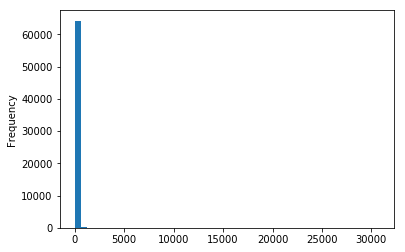

In [19]:

pd.Series(np.array(list(freq.values()))).plot(kind='hist',bins=50)

The plot is not very helpful. But it shows you that, as many things in life, the large majority of entities only occur once, and only very few are highly frequent.



Logging these values dampens, of course, these differences.

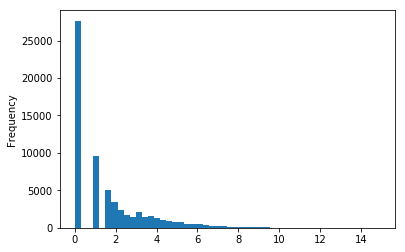

In [20]:
pd.Series(np.log2(list(freq.values()))).plot(kind='hist',bins=50)

The code below shows how to easily extract rows that contain items of interest. You can change the `selected_df` variable to search for other tokens.

In [21]:
selected_sf = ['cat','dog']
filtered = annotation_df[annotation_df.surfaceForm.str.lower().isin(selected_sf)]
filtered.head()

,URI,offset,percentageOfSecondRank,similarityScore,source_file,support,surfaceForm,types
256,http://dbpedia.org/resource/Dog,22586,3.874481e-06,0.999996,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,10004,dog,"{DBpedia:Eukaryote, DBpedia:Species, DBpedia:Mammal, DBpedia:Animal}"
261,http://dbpedia.org/resource/Dog,22961,3.499789e-08,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,10004,dog,"{DBpedia:Eukaryote, DBpedia:Species, DBpedia:Mammal, DBpedia:Animal}"
1069,http://dbpedia.org/resource/Cat,134426,3.732187e-06,0.999996,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,5153,cat,"{DBpedia:Eukaryote, DBpedia:Species, DBpedia:Mammal, DBpedia:Animal}"
1139,http://dbpedia.org/resource/Dog,146034,2.669787e-09,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,10004,dog,"{DBpedia:Eukaryote, DBpedia:Species, DBpedia:Mammal, DBpedia:Animal}"
1141,http://dbpedia.org/resource/Dog,147516,9.758815e-09,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,10004,dog,"{DBpedia:Eukaryote, DBpedia:Species, DBpedia:Mammal, DBpedia:Animal}"



### Types

The surfaceForm column allows you to find how many entities were found in your corpus. However, it does not really help for organizing and filtering your corpus.  64400 different items is still a lot to handle, also we can not guess what these entities actually are, do they refer to things, people, events? 

Luckily, the `types` column provides an alternative way to find topics in your corpus and classify individual documents.

The line below prints the URI and types for a specific row.

#### Question

Change the index variable to study how URI

In [22]:
index = 1000
print(annotation_df.iloc[index].URI,
      "\n",
      annotation_df.iloc[index].surfaceForm,
       "\n",
      annotation_df.iloc[index].types)

http://dbpedia.org/resource/England 
 England 
 {'Schema:Country', 'Schema:Place', 'DBpedia:Country', 'DBpedia:Place', 'DBpedia:PopulatedPlace'}


Types offer convenient way to categorize your texts. The number of unique types is much lower than the number of surface forms.

In [23]:
set_of_all_types = set().union(*annotation_df.types)
print(len(set_of_all_types))

370


To print the complete set, run the code in the cell below.

In [24]:
print(set_of_all_types)

{'', 'DBpedia:Ship', 'DBpedia:Play', 'DBpedia:Grape', 'DBpedia:LaunchPad', 'DBpedia:ReligiousBuilding', 'Schema:Book', 'Schema:EducationalOrganization', 'Schema:SportsEvent', 'Schema:Library', 'DBpedia:MilitaryPerson', 'DBpedia:Theatre', 'DBpedia:FloweringPlant', 'DBpedia:SpaceMission', 'Schema:MusicAlbum', 'DBpedia:BiologicalDatabase', 'DBpedia:GivenName', 'DBpedia:Activity', 'DBpedia:Agent', 'Schema:AdministrativeArea', 'Schema:Language', 'DBpedia:Artery', 'DBpedia:Jockey', 'DBpedia:Place', 'DBpedia:HistoricBuilding', 'DBpedia:Beverage', 'DBpedia:SoccerLeague', 'DBpedia:Cricketer', 'Schema:StadiumOrArena', 'DBpedia:SportsSeason', 'Http://xmlns.com/foaf/0.1/Person', 'DBpedia:Non-ProfitOrganisation', 'DBpedia:Bird', 'DBpedia:Genre', 'DBpedia:GovernmentAgency', 'DBpedia:TelevisionShow', 'DBpedia:Artist', 'DBpedia:EthnicGroup', 'DBpedia:ChemicalCompound', 'DBpedia:Cartoon', 'DBpedia:ComicsCreator', 'DBpedia:Album', 'DBpedia:City', 'Schema:Country', 'DBpedia:Cleric', 'DBpedia:Criminal', '

In [25]:
list_of_all_types = [t for ts in annotation_df.types for t in ts]
Counter(list_of_all_types).most_common(10)

[('', 490026),
 ('Schema:Place', 170940),
 ('DBpedia:Place', 170940),
 ('DBpedia:PopulatedPlace', 154413),
 ('DBpedia:Agent', 126314),
 ('DBpedia:Settlement', 91875),
 ('Schema:Organization', 76230),
 ('DBpedia:Organisation', 76230),
 ('Schema:Person', 50084),
 ('Http://xmlns.com/foaf/0.1/Person', 50084)]

#### Question

Can you plot the distribution of the types? You can reuse the code above, of course.

In [0]:
# enter code here

Filtering by type, also allows you to discover particular topics in your corpus. For example, if you are interested in mentions to cinema and film culture, you can filter row and retain those that either contain 'Schema:Movie' or 'DBpedia:Film' as a type. To select documents based on other entities, simply change the items in the 
`criteria` set.

In [0]:
criteria = {'Schema:Movie','DBpedia:Film'}
filter_by_types = lambda types, criteria: True if types & criteria else False
annotation_df["filtered_by_type"] = annotation_df.types.apply(filter_by_types,criteria=criteria)

In [28]:
annotation_df[annotation_df["filtered_by_type"] == True]

,URI,offset,percentageOfSecondRank,similarityScore,source_file,support,surfaceForm,types,filtered_by_type
1053,http://dbpedia.org/resource/I_Confess_(film),130311,8.784348e-08,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,25,I confess,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
1223,http://dbpedia.org/resource/I_Confess_(film),172481,1.036242e-07,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,25,I confess,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
1458,http://dbpedia.org/resource/Jewel_Robbery,212172,0.000000e+00,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,3,Jewel Robbery,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
1721,http://dbpedia.org/resource/I_Confess_(film),258020,5.331881e-07,0.999998,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,25,I confess,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
1808,http://dbpedia.org/resource/Breathless_(1960_film),275291,8.200858e-03,0.991552,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,98,breathless,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
1991,http://dbpedia.org/resource/Worth_Winning,300714,0.000000e+00,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,6,worth winning,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
2059,http://dbpedia.org/resource/Breathless_(1960_film),312591,3.222890e-01,0.566693,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,98,breathless,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
2071,http://dbpedia.org/resource/Sparkle_(1976_film),314398,5.897498e-02,0.925431,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,121,sparkle,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
2294,http://dbpedia.org/resource/I_Confess_(film),353631,3.826070e-08,1.000000,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,25,I confess,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True
2538,http://dbpedia.org/resource/I_Confess_(film),404585,2.655881e-06,0.999992,TheStrandMagazineAnIllustratedMonthly/TheStrandMagazine1892aVol.IiiJan-...,25,I confess,"{DBpedia:Film, DBpedia:Work, Schema:CreativeWork, Schema:Movie}",True


Lastly, plotting annotations over time:

In [0]:
import re
pattern = re.compile(r'1[0-9]{3}')
get_year = lambda text: int(pattern.findall(text)[0])
annotation_df['Year'] = annotation_df.source_file.apply(get_year)


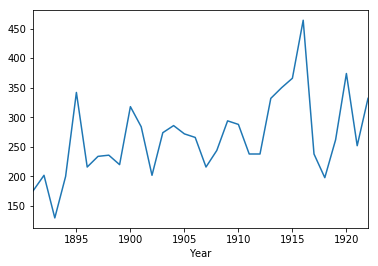

In [30]:
entities = {'Schema:Movie','DBpedia:Film'}
count_types = lambda types, entities: len(types & criteria)
annotation_df["counted_entities"] = annotation_df.types.apply(count_types,entities=entities)
annotation_df.groupby("Year").sum()["counted_entities"].plot()

## Filtering annotations with SPARQL

Odds are, you're not interested in **all** the "things" that Spotlight has found in the documents.

Let's retrieve a subset of entity IDs via SPARQL, in order to find out which of these entities are mentioned in the documents.

In [0]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
sparql.setReturnFormat(JSON)


def traverse_subcategories(root_name, depth=3, limit=1000):
    category_query = """
        SELECT ?category ?resource
        WHERE {
            ?category skos:broader{0, %i} dbc:%s .
            ?resource dct:subject ?category . 
        }
        LIMIT %i
    """ % (depth, root_name, limit)
    
    collected_entities = defaultdict(set)
    page_iterator = tqdm_notebook(range(50), desc='Result page')
    for page in page_iterator:
        sparql.setQuery(category_query + f'OFFSET {page * limit}')
        result_page = sparql.query().convert()
        bindings = result_page['results']['bindings']
        if not len(bindings):
            page_iterator.close()
            print(f'Exhausted available results at page {page}')
            break
            
        for binding in bindings:
            category = binding['category']['value']
            resource = binding['resource']['value']
            collected_entities[category].add(resource)
    else:
        print('Reached limit of 50 pages: this should be enough for now')

    return collected_entities

In [32]:
select_root = interactive(
    traverse_subcategories, 
    {'manual': True}, 
    root_name='Figures_of_speech',
    depth=IntSlider(value=3, min=0, max=5),
    limit=IntSlider(value=1000, min=100, max=2000)
)
display.display(select_root)

interactive(children=(Text(value='Figures_of_speech', description='root_name'), IntSlider(value=3, description…

The `root_name` input above is used to select the broadest category of interest. After clicking "run interact", DBpedia's SPARQL endpoint is queried for all members of the category, and when `depth > 0` it proceeds to do so for several levels of more specific sub-categories.

Some interesting examples to try on the Strand Magazine dataset, and perhaps on others:

- Characters_in_British_novels_of_the_19th_century_by_writer
- Desserts (depth = 1)
- Tea_ceremony

After collecting this partial (flattened) tree of the Wikipedia category network, we are able to display thematic subsets of all generated entity links.

In [0]:
entities_per_category = select_root.result

def get_filtered_annotations(selected_category):
    selected_entities = entities_per_category[selected_category]
    category_mask = annotation_df.URI.isin(selected_entities)
    return annotation_df[category_mask]

interact(
    get_filtered_annotations, 
    selected_category=entities_per_category.keys()
)

This kind of thematic filtering is highly versatile, but the resulting table of entity links is ill-suited for scholarly consumption.

To achieve a better result, we can look at the "snippets" that surround the filtered annotations in the source documents.

In [0]:
def get_link_snippet(matching_link):
    link_start = matching_link.offset
    link_end = link_start + len(matching_link.surfaceForm)

    pre_length = 100
    post_length = 110 - (link_end - link_start)
    pre_start = max(0, link_start - pre_length)
    post_end = link_end + post_length
    
    doc_mask = (document_df.file_path == matching_link.source_file)
    doc_text = document_df.loc[doc_mask].text_content.item()
    pre_ellipsis = '...' if pre_start else ''
    pre = doc_text[pre_start:link_start]
    surface_form = doc_text[link_start:link_end]
    post = doc_text[link_end:post_end]
    post_ellipsis = '...' if post_end < len(doc_text) else ''

    return f"""
        <p style="color: var(--colab-primary-text-color);">
            {pre_ellipsis}{pre}<u>{surface_form}</u>{post}{post_ellipsis}
        </p>
    """


def get_filtered_snippets(selected_category):
    filtered_annotations = get_filtered_annotations(selected_category)
    snippet_series = filtered_annotations.apply(get_link_snippet, axis=1)
    if snippet_series.empty:
        return 'No matched annotations for this category'
    return display.HTML(snippet_series.str.cat(sep='\n'))

In [36]:
entities_per_category = select_root.result

interact(
    get_filtered_snippets, 
    selected_category=entities_per_category.keys()
)

interactive(children=(Dropdown(description='selected_category', options=('http://dbpedia.org/resource/Category…

<function __main__.get_filtered_snippets>

## DIY project

We do not provide a clear-cut goal for this exercise, because that should depend on your own interests and motivations. We provide some general directions for you, but suggest that you start by defining a clear aim for your own project.

Possible directions to take:

*   Explore the provided "Strand Magazine" corpus:
  -  formulating a (thematic) research question;
  -  reflecting on the quality of the results, and which improvements would be needed to use this for actual research.
*   Load, annotate, and explore your own data:
  -  e.g. using a small or partial corpus;
  -  different methods to load documents are provided in a [separate notebook](https://colab.research.google.com/drive/1EjE1uLkw61bMBtGLOYshfgjI-Wwb1-rJ).
*   Filter annotations with custom SPARQL queries:
  -  There is no particular reason to use Wikipedia categories, other than their flexibility and coverage;
  -  Many examples of more specific queries against DBpedia can be found on the web.
     - e.g. http://sites.linkeddata.center/help/devop/examples/sparql-examples
*   Replace the English DBpedia SPARQL endpoint with a different Linked Data source:
  -  Such as Wikidata or DBpedia in other languages:
     - https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial
     - http://fr.dbpedia.org/sparql
     - http://de.dbpedia.org/sparql
     - http://ja.dbpedia.org/sparql
     - http://nl.dbpedia.org/sparql
     - http://pt.dbpedia.org/sparql
  - Use the [Same Thing Service](http://dev.dbpedia.org/Global_IRI_Resolution_Service) to translate the URIs to match the Spotlight output.